## Obtaining Sum of Frame Differences for $n$ classes

### Import Dependencies  

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import collections
import re

### Loading Filename of Dataset from a ZIP file into a Python Dictionary

In [2]:
def list_files_from_zip_path(path):
    """ 
    List the files in each class of the dataset given a PATH with the zip file
    Args:
    PATH - path of the zip file saved in the same folder
    
    Returns:
    file_names - list all files read in the zip.file, including folder names
    """
    file_names = []
    with zipfile.ZipFile(path, 'r') as zip:
        for file_info in zip.infolist():
            file_names.append(file_info.filename)
    return file_names

In [3]:
# Extract all files from zip. Separate the videos from folders names

file_names = list_files_from_zip_path('clips.zip')
videos = [f for f in file_names if f.endswith('MOV')]
folders = [f for f in file_names if not f.endswith('MOV')]

In [4]:
def get_files_per_class(videos, folders):
    """ Compile videos according to class
    
    Args:
    videos - filename of videos
    folders - filename of folders

    Returns:
    video_and_class - dictionary with class (key) and videos (values)
    """
    video_and_class = collections.defaultdict(list)

    # Extracts the class number from the folder name
    for folder in folders:
        class_key = int(re.findall(r'\d+', folder)[0])

        for video in videos:
            if folder in video:
                video_and_class[class_key].append(video)
    return video_and_class

In [5]:
# returns a dictionary with paths of subfolder and each videos inside
file_dictionary = get_files_per_class(videos, folders)

#### Loading Subset of Dataset

In [6]:
def subset_data(file_dictionary, num_class=2, num_videos=20):
    """ 
    Selects a subset of the complete videos dictionary containing the first num_class classes.

    Args:
    file_dictionary - dictionary of the complete videos with class
    num_class - number of classes in the subset

    Return:
    files_subset - A subset dictionary with class (keys) and values (videos)
    class_subset - list of the keys of files_subset
    """
    subset = {k: file_dictionary[k][:num_videos] for k in np.sort(list(file_dictionary))[:num_class]}
    return subset, list(subset.keys())

In [1]:
from modules.module_GenerateDataset import fslDataset as fsl

### Sum of Frame Difference

#### Helper Functions

In [8]:
def get_video_properties(cap):
  ''' Returns number of frames, height, and width of a video'''
  n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  ret, frame = cap.read()
  if ret:
    return n_frames, frame.shape[0], frame.shape[1]

def frame_placeholders(n, height, width):
  """ Returns a list of length n with entries np.zeros((height, width), dtype.uint8) """
  pholder = []
  for i in range(n):
    pholder.append(np.zeros((height, width), dtype=np.uint8))
  return pholder

# def frame_to_rgb(frame):
#   """ Splits the frame into arrays of R, G, and B """
#   r, g, b = cv2.split(frame)
#   return np.asarray([r, g, b])

def reduce_noise(frame, upperthresh, lowerthresh):
  """ Changes pixel value to 0 if value > upperthresh or value < lowerthresh """
  # colors = frame_to_rgb(frame)
  # for color in colors:
  #   color[color < lowerthresh] = 0
  #   color[color > upperthresh] = 0
  # return cv2.merge([colors[0],colors[1], colors[2]])
  frame[frame < lowerthresh] = 0
  frame[frame > upperthresh] = 0
  return frame

def save_temporal_features(frame, upperthresh, frame_idx):
  """ Saves the temporal features of the frame difference """
  # colors = frame_to_rgb(frame)
  # for color in colors:
  #   color[color!=0] = np.floor(upperthresh/frame_idx)
  # return cv2.merge([colors[0],colors[1], colors[2]])
  frame[frame!=0] = np.floor(upperthresh/frame_idx)
  return frame

def to_onerow(sum_frame, height, width):
  """ Converts the frame matrix to a one-row array """
  return sum_frame.reshape(1, height*width)

#### Main Sum of Frame Difference Function

In [9]:
def SumFrameDiff(path):

    # Importing video files
    cap = cv2.VideoCapture(path)

    # Video properties
    n_frames, height, width = get_video_properties(cap)

    # frame interval
    frame_int = 1

    # create placeholders
    [prev_frame, diff_frame, sum_frame] = frame_placeholders(3, height, width)

    for frame in range(n_frames):
        ret, img = cap.read()
        if ret == False:
            break

        if frame % frame_int == 0:
            curr_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # save and pass first frame
            if frame == 0:
                prev_frame = curr_frame
            else:
                # frame difference
                diff_frame = cv2.subtract(curr_frame, prev_frame)

                # noise reduction
                diff_frame = reduce_noise(diff_frame, upperthresh=200, lowerthresh=55)
                
                # save temporal feature for summing
                diff_frame = save_temporal_features(diff_frame, upperthresh=255, frame_idx=frame)

                # save in sum_frame
                sum_frame = cv2.add(sum_frame, diff_frame)

                prev_frame = curr_frame
    cap.release()

    sum_frame = to_onerow(sum_frame, height, width)
    return sum_frame


#### Implementation

In [ ]:
# for loop trial
# prints all paths of clips (according to class)
for k in class_subset:
    for value_idx in range(len(files_subset[k])):
        print(list(files_subset.values())[k][value_idx])

In [13]:
class_and_sumframes = collections.defaultdict(list)

for k in class_subset:
    
    for value_idx in range(len(files_subset[k])):

        # obtains path of the video from class k
        path = list(files_subset.values())[k][value_idx]

        # perform sum of frame difference on video
        sum_frame = SumFrameDiff(path)

        # add 1D sum_frame to dictionary per class
        class_and_sumframes[k].extend(sum_frame)

### Exporting Dictionary of Class and SumFrames to an Excel File

In [16]:
import pandas as pd

df = pd.DataFrame(data=class_and_sumframes)
df.to_excel('class_and_sumframes.xlsx', index=False)

In [14]:
sum_frame = SumFrameDiff('clips/3/6.MOV')

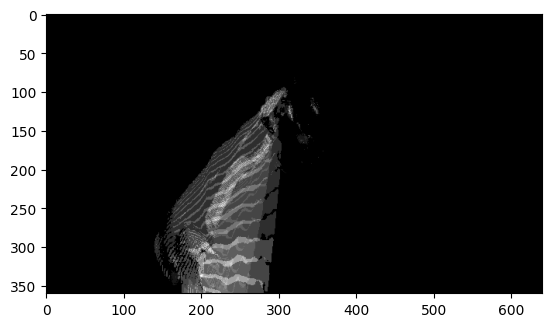

In [15]:
plt.imshow(sum_frame.reshape(360, 640), cmap='gray')